In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import  StandardScaler
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, BatchNormalization, Input, Conv1D, MaxPooling1D
from keras.models import Model
import keras.backend as K
from keras import metrics
from keras.optimizers import Adam
from keras import regularizers
from keras.losses import binary_crossentropy
from sklearn.metrics import roc_auc_score


Using TensorFlow backend.


In [2]:
# LOAD DATA
train=pd.read_csv("./../input/train.csv")
test=pd.read_csv("./../input/test.csv")

In [3]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
train.describe(include='all')

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
unique,200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,train_188999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.305430,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,...,24.259300,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,NaN,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.587830,4.322325,0.541614,5.179559,3.119978,2.249730,...,10.880263,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.5

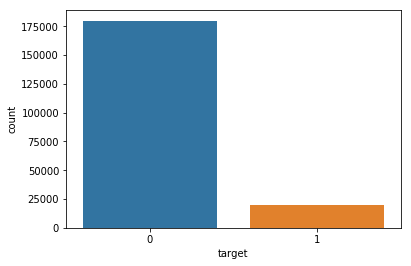

In [5]:
sns.countplot(train["target"])

In [7]:
train["target"].value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [8]:
df_train = train.drop(["ID_code","target"],axis=1)
y_train = train["target"]
df_test = test.drop(["ID_code"],axis=1)

In [34]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
df_train_rus, y_train_rus = rus.fit_sample(df_train, y_train)

In [10]:
unique, counts = np.unique(y_train_rus, return_counts=True)
dict(zip(unique, counts))

{0: 20098, 1: 20098}

In [11]:
type(y_train_rus)

numpy.ndarray

In [12]:
sc = StandardScaler()
df_train = sc.fit_transform(df_train_rus)
df_test = sc.fit_transform(df_test)

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [14]:
type(df_train)

numpy.ndarray

In [15]:
df_train = pd.DataFrame(df_train)
y_train = pd.DataFrame(y_train_rus)
df_test = pd.DataFrame(df_test)

In [27]:
def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

In [17]:
def _Model():
    inp = Input(shape=(200, 1))
    d1 = Dense(128, activation='sigmoid')(inp)
    d2 = Conv1D(64, 2, activation="relu", kernel_initializer="uniform")(d1)
    d3 = Dense(32, activation='sigmoid')(d2)
    d4 = Dense(16, activation='relu')(d3)
    f1 = Flatten()(d4)
    preds = Dense(1, activation='sigmoid')(f1)
    model = Model(inputs=inp, outputs=preds)
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy',recall])
    return model

In [18]:
print(_Model().summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 1)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 200, 128)          256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 199, 64)           16448     
_________________________________________________________________
dense_2 (Dense)              (None, 199, 32)           2080      
_________________________________________________________________
dense_3 (Dense)              (None, 199, 16)           528       
_________________________________________________________________
flatten_1 (Flatten)          (None, 3184)              0         
_________________________________________________________________
dens

In [19]:
preds = []
c = 0
oof_preds = np.zeros((len(df_train), 1))
for train, valid in cv.split(df_train, y_train):
    print("VAL %s" % c)
    X_train = np.reshape(df_train.iloc[train].values, (-1, 200, 1))
    y_train_ = y_train.iloc[train].values
    X_valid = np.reshape(df_train.iloc[valid].values, (-1, 200, 1))
    y_valid = y_train.iloc[valid].values
    model = _Model()
    history=model.fit(X_train, y_train_, validation_data=(X_valid, y_valid), epochs=20, verbose=2, batch_size=256)
    #print(model.evaluate(X_valid, y_valid))
    #model.load_weights('cv_{}.h5'.format(c))
    
    X_test = np.reshape(df_test.values, (200000, 200, 1))
    curr_preds = model.predict(X_test, batch_size=2048)
    oof_preds[valid] = model.predict(X_valid)
    preds.append(curr_preds)
    c += 1
auc = roc_auc_score(y_train, oof_preds)
print("CV_AUC: {}".format(auc))

VAL 0
Instructions for updating:
Use tf.cast instead.
Train on 32156 samples, validate on 8040 samples
Epoch 1/20
 - 4s - loss: 0.6944 - acc: 0.5066 - recall: 0.5275 - val_loss: 0.6924 - val_acc: 0.5307 - val_recall: 0.0912
Epoch 2/20
 - 1s - loss: 0.6776 - acc: 0.5848 - recall: 0.5569 - val_loss: 0.6095 - val_acc: 0.6779 - val_recall: 0.3099
Epoch 3/20
 - 1s - loss: 0.5317 - acc: 0.7338 - recall: 0.7322 - val_loss: 0.5093 - val_acc: 0.7442 - val_recall: 0.4415
Epoch 4/20
 - 1s - loss: 0.4727 - acc: 0.7733 - recall: 0.7722 - val_loss: 0.4615 - val_acc: 0.7828 - val_recall: 0.4154
Epoch 5/20
 - 1s - loss: 0.4423 - acc: 0.7934 - recall: 0.7906 - val_loss: 0.4406 - val_acc: 0.7938 - val_recall: 0.4184
Epoch 6/20
 - 1s - loss: 0.4261 - acc: 0.8022 - recall: 0.7954 - val_loss: 0.4336 - val_acc: 0.7950 - val_recall: 0.4280
Epoch 7/20
 - 1s - loss: 0.4193 - acc: 0.8089 - recall: 0.8026 - val_loss: 0.4272 - val_acc: 0.8000 - val_recall: 0.4073
Epoch 8/20
 - 1s - loss: 0.4141 - acc: 0.8114 - re

Epoch 5/20
 - 1s - loss: 0.4438 - acc: 0.7913 - recall: 0.7882 - val_loss: 0.4367 - val_acc: 0.7961 - val_recall: 0.4029
Epoch 6/20
 - 1s - loss: 0.4363 - acc: 0.7958 - recall: 0.7906 - val_loss: 0.4726 - val_acc: 0.7757 - val_recall: 0.4596
Epoch 7/20
 - 1s - loss: 0.4285 - acc: 0.8021 - recall: 0.7967 - val_loss: 0.4237 - val_acc: 0.8057 - val_recall: 0.4270
Epoch 8/20
 - 1s - loss: 0.4200 - acc: 0.8055 - recall: 0.7988 - val_loss: 0.4341 - val_acc: 0.7991 - val_recall: 0.4528
Epoch 9/20
 - 1s - loss: 0.4184 - acc: 0.8063 - recall: 0.7996 - val_loss: 0.4283 - val_acc: 0.8007 - val_recall: 0.4503
Epoch 10/20
 - 1s - loss: 0.4115 - acc: 0.8100 - recall: 0.8044 - val_loss: 0.4166 - val_acc: 0.8110 - val_recall: 0.4013
Epoch 11/20
 - 1s - loss: 0.4142 - acc: 0.8089 - recall: 0.8001 - val_loss: 0.4117 - val_acc: 0.8134 - val_recall: 0.4217
Epoch 12/20
 - 1s - loss: 0.4082 - acc: 0.8123 - recall: 0.8046 - val_loss: 0.4145 - val_acc: 0.8102 - val_recall: 0.4380
Epoch 13/20
 - 1s - loss: 0.4

In [21]:
# SAVE DATA
preds = np.asarray(preds)
preds = preds.reshape((5, 200000))
preds_final = np.mean(preds.T, axis=1)
submission = pd.read_csv('./../input/sample_submission.csv')
submission['target'] = preds_final

In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'val_recall', 'loss', 'acc', 'recall'])

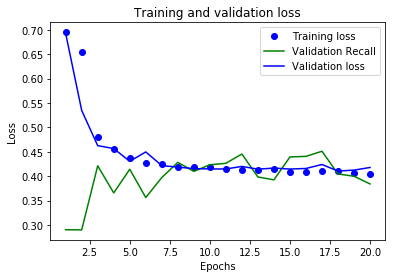

In [23]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
recall = history.history['recall']
val_recall = history.history['val_recall']
epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_recall, 'g-', label='Validation Recall')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

In [28]:
def _Model_1():
    inp = Input(shape=(200, 1))
    d1 = Dense(64, activation='sigmoid')(inp)
    d2 = Conv1D(128, 2, activation="relu", kernel_initializer="uniform")(d1)
    d3 = Dense(32, activation='sigmoid')(d2)
    d4 = Dense(16, activation='relu')(d3)
    f1 = Flatten()(d4)
    preds = Dense(1, activation='sigmoid')(f1)
    model = Model(inputs=inp, outputs=preds)
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy', recall])
    return model

In [29]:
print(_Model_1().summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 200, 1)            0         
_________________________________________________________________
dense_29 (Dense)             (None, 200, 64)           128       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 199, 128)          16512     
_________________________________________________________________
dense_30 (Dense)             (None, 199, 32)           4128      
_________________________________________________________________
dense_31 (Dense)             (None, 199, 16)           528       
_________________________________________________________________
flatten_8 (Flatten)          (None, 3184)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 3185      
Total para

In [30]:
preds_1 = []
c = 0
oof_preds = np.zeros((len(df_train), 1))
for train, valid in cv.split(df_train, y_train):
    print("VAL %s" % c)
    X_train = np.reshape(df_train.iloc[train].values, (-1, 200, 1))
    y_train_ = y_train.iloc[train].values
    X_valid = np.reshape(df_train.iloc[valid].values, (-1, 200, 1))
    y_valid = y_train.iloc[valid].values
    model = _Model_1()
    history=model.fit(X_train, y_train_, validation_data=(X_valid, y_valid), epochs=20, verbose=2, batch_size=256)
    #print(model.evaluate(X_valid, y_valid))
    #model.load_weights('cv_{}.h5'.format(c))
    
    X_test = np.reshape(df_test.values, (200000, 200, 1))
    curr_preds = model.predict(X_test, batch_size=2048)
    oof_preds[valid] = model.predict(X_valid)
    preds_1.append(curr_preds)
    c += 1
auc = roc_auc_score(y_train, oof_preds)
print("CV_AUC: {}".format(auc))

VAL 0
Train on 32156 samples, validate on 8040 samples
Epoch 1/20
 - 2s - loss: 0.6952 - acc: 0.5198 - recall: 0.4572 - val_loss: 0.6905 - val_acc: 0.5565 - val_recall: 0.4344
Epoch 2/20
 - 1s - loss: 0.6181 - acc: 0.6592 - recall: 0.7085 - val_loss: 0.5353 - val_acc: 0.7239 - val_recall: 0.3973
Epoch 3/20
 - 1s - loss: 0.5156 - acc: 0.7429 - recall: 0.7430 - val_loss: 0.5106 - val_acc: 0.7415 - val_recall: 0.3544
Epoch 4/20
 - 1s - loss: 0.4853 - acc: 0.7657 - recall: 0.7665 - val_loss: 0.4843 - val_acc: 0.7648 - val_recall: 0.3846
Epoch 5/20
 - 1s - loss: 0.4624 - acc: 0.7822 - recall: 0.7779 - val_loss: 0.4643 - val_acc: 0.7779 - val_recall: 0.3986
Epoch 6/20
 - 1s - loss: 0.4477 - acc: 0.7901 - recall: 0.7868 - val_loss: 0.4530 - val_acc: 0.7867 - val_recall: 0.4129
Epoch 7/20
 - 1s - loss: 0.4384 - acc: 0.7954 - recall: 0.7907 - val_loss: 0.4488 - val_acc: 0.7861 - val_recall: 0.4159
Epoch 8/20
 - 1s - loss: 0.4300 - acc: 0.8008 - recall: 0.7954 - val_loss: 0.4432 - val_acc: 0.792

Epoch 7/20
 - 1s - loss: 0.4314 - acc: 0.8005 - recall: 0.7943 - val_loss: 0.4242 - val_acc: 0.8085 - val_recall: 0.4311
Epoch 8/20
 - 1s - loss: 0.4260 - acc: 0.8039 - recall: 0.7957 - val_loss: 0.4311 - val_acc: 0.8009 - val_recall: 0.3778
Epoch 9/20
 - 1s - loss: 0.4220 - acc: 0.8043 - recall: 0.7978 - val_loss: 0.4167 - val_acc: 0.8139 - val_recall: 0.4143
Epoch 10/20
 - 1s - loss: 0.4182 - acc: 0.8065 - recall: 0.7983 - val_loss: 0.4141 - val_acc: 0.8144 - val_recall: 0.4174
Epoch 11/20
 - 1s - loss: 0.4154 - acc: 0.8077 - recall: 0.8008 - val_loss: 0.4109 - val_acc: 0.8149 - val_recall: 0.4219
Epoch 12/20
 - 1s - loss: 0.4134 - acc: 0.8082 - recall: 0.8009 - val_loss: 0.4166 - val_acc: 0.8085 - val_recall: 0.4420
Epoch 13/20
 - 1s - loss: 0.4139 - acc: 0.8098 - recall: 0.8031 - val_loss: 0.4216 - val_acc: 0.8077 - val_recall: 0.4514
Epoch 14/20
 - 1s - loss: 0.4113 - acc: 0.8119 - recall: 0.8037 - val_loss: 0.4109 - val_acc: 0.8138 - val_recall: 0.4161
Epoch 15/20
 - 1s - loss: 0

In [32]:
# SAVE DATA
preds_1 = np.asarray(preds_1)
preds_1 = preds_1.reshape((5, 200000))
preds_final = np.mean(preds_1.T, axis=1)
submission_1 = pd.read_csv('./../input/sample_submission.csv')
submission_1['target'] = preds_final

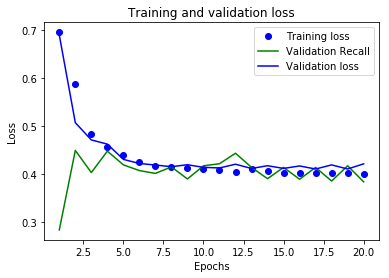

In [33]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
recall = history.history['recall']
val_recall = history.history['val_recall']
epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_recall, 'g-', label='Validation Recall')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()